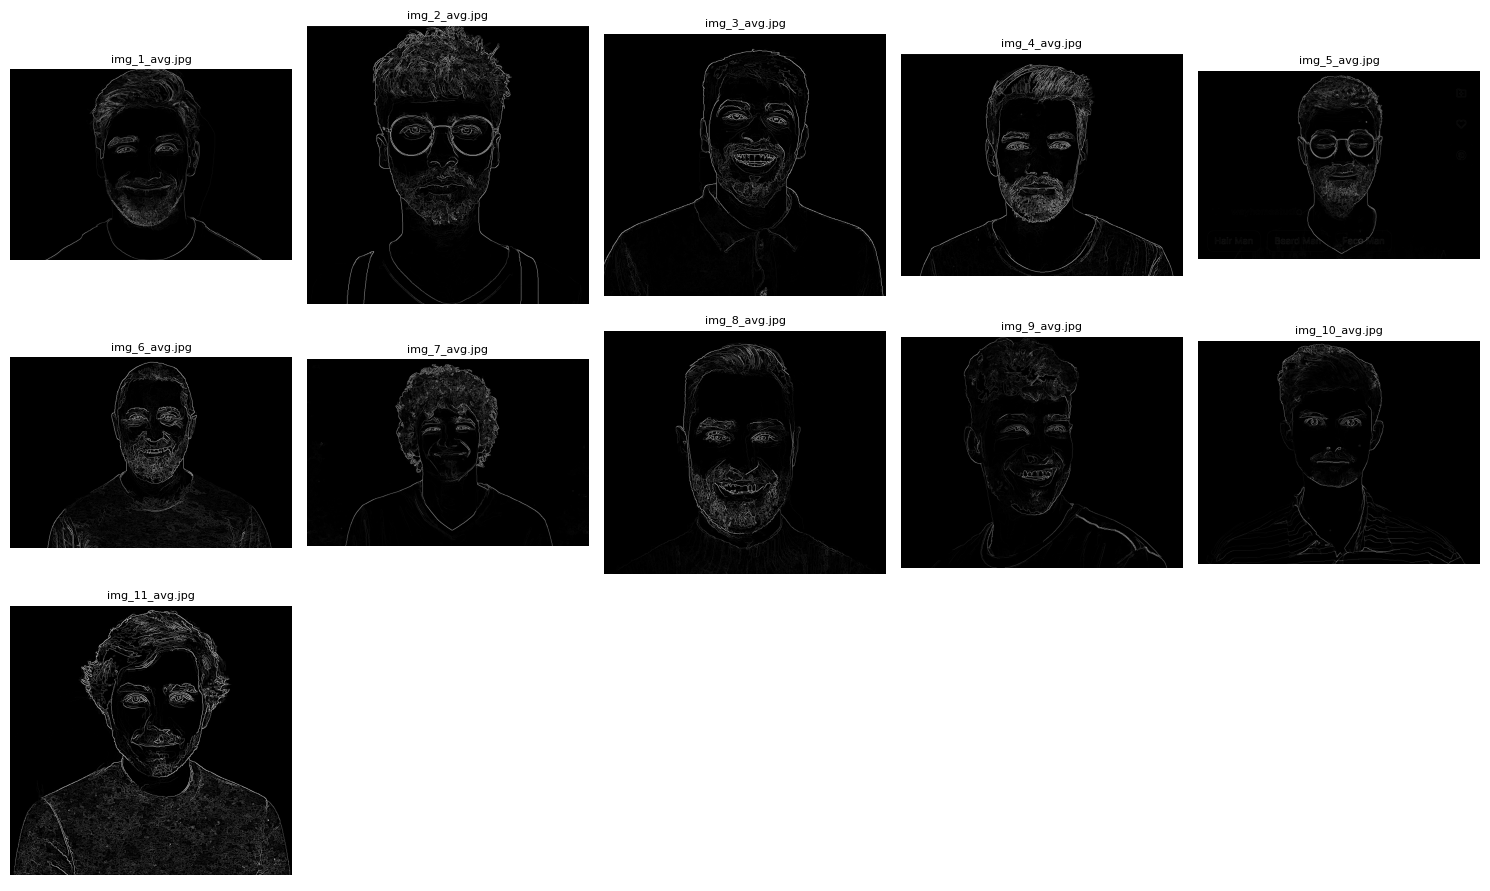

In [9]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

def canny_edge_detection(input_folder, output_folder, threshold_pairs):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get list of all files in the input folder
    files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

    processed_images = []

    # Process each file with each threshold pair
    for file_index, file in enumerate(files):
        img_path = os.path.join(input_folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        edge_images = []
        for i, (lower, upper) in enumerate(threshold_pairs):
            edges = cv2.Canny(img, lower, upper)
            edge_images.append(edges)
            output_filename = f"image_{file_index+1}_{lower}_{upper}.jpg"
            output_path = os.path.join(output_folder, output_filename)
            # cv2.imwrite(output_path, edges)
            # processed_images.append((edges, output_filename))
        
        # Average all edge detection results
        avg_edges = np.mean(edge_images, axis=0).astype(np.uint8)
        avg_output_filename = f"img_{file_index+1}_avg.jpg"
        avg_output_path = os.path.join(output_folder, avg_output_filename)
        cv2.imwrite(avg_output_path, avg_edges)
        processed_images.append((avg_edges, avg_output_filename))

    # Plot the processed images in a grid with 5 columns
    num_images = len(processed_images)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for i, (img, title) in enumerate(processed_images):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(title, fontsize=8)
        axes[i].axis('off')

    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
input_folder = 'inputs'
output_folder = 'outputs'
def generate_threshold_pairs(start, end, step):
    threshold_pairs = [(lower, upper) 
                       for lower in range(start, end, step) 
                       for upper in range(lower + step, end + step, step)]
    return threshold_pairs
threshold_pairs = generate_threshold_pairs(0,250,10)
canny_edge_detection(input_folder, output_folder, threshold_pairs)


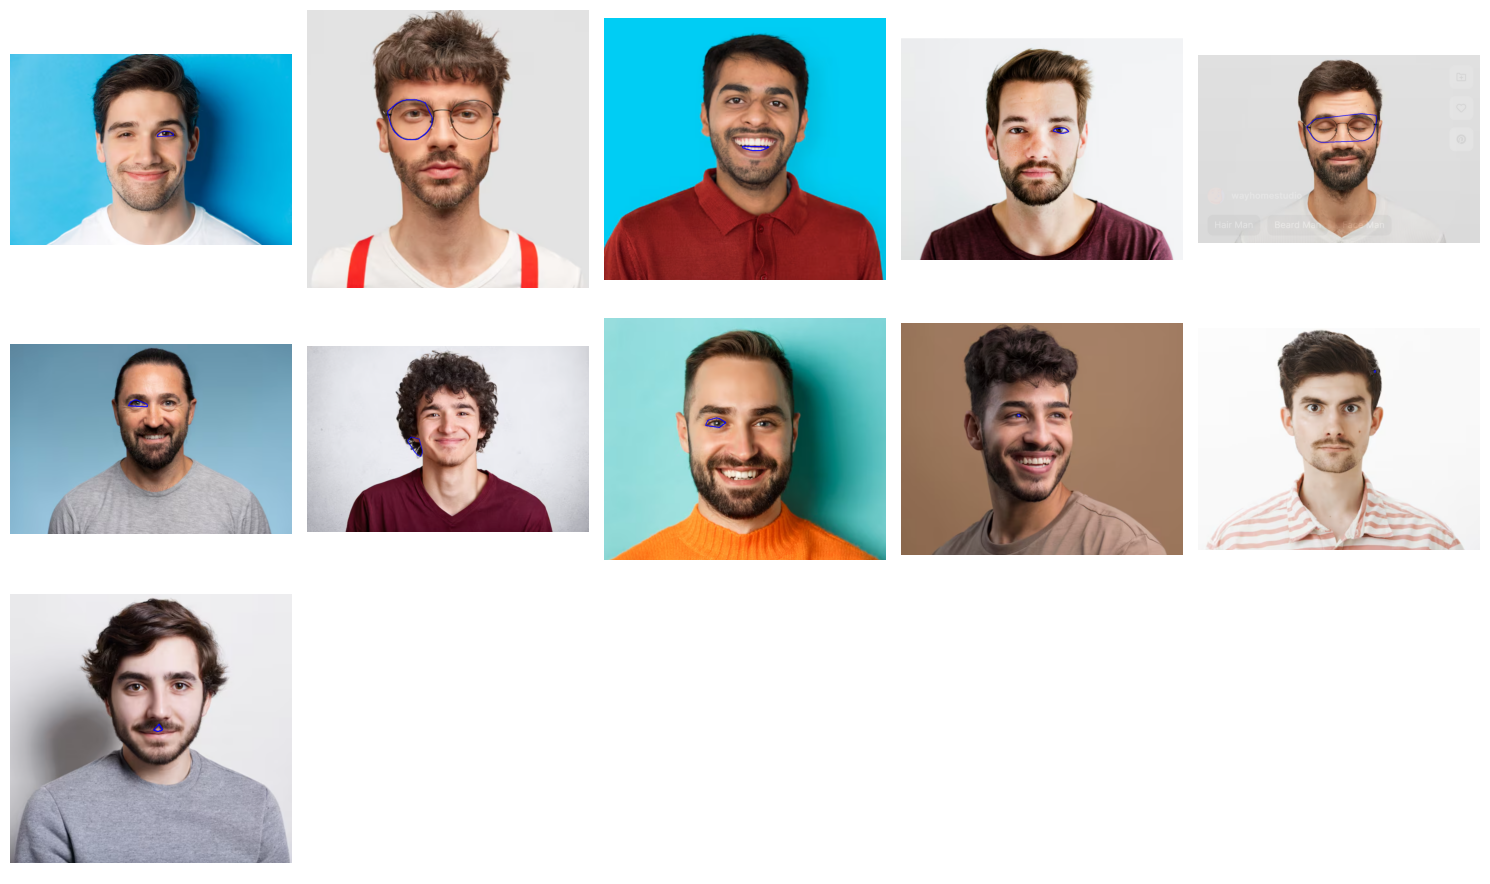

In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def detect_and_draw_features(input_folder, output_folder, cascades):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]
    processed_images = []

    for file in files:
        img_path = os.path.join(input_folder, file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect features
        features = {}
        for feature, (cascade, color) in cascades.items():
            detector = cv2.CascadeClassifier(cascade)
            detected = detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
            features[feature] = (detected, color)

        # Draw rectangles around features and find convex hull for faces
        for feature, (detected, color) in features.items():
            if feature == 'face':
                for (x, y, w, h) in detected:
                    # Extract the face region
                    face = gray[y:y+h, x:x+w]
                    
                    # Use Canny edge detection to find edges in the face region
                    edges = cv2.Canny(face, 100, 200)
                    
                    # Find contours in the edges
                    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                    
                    # Draw the largest contour (which should be the face shape)
                    if contours:
                        largest_contour = max(contours, key=cv2.contourArea)
                        
                        # Calculate the convex hull of the largest contour
                        hull = cv2.convexHull(largest_contour)
                        
                        # Draw the convex hull on the original image
                        hull_points = hull + np.array([x, y])  # Adjust the position to the original image
                        cv2.polylines(img, [hull_points], isClosed=True, color=color, thickness=2)
            else:
                for (x, y, w, h) in detected:
                    cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)

        output_path = os.path.join(output_folder, file)
        cv2.imwrite(output_path, img)
        processed_images.append(img)

    # Display images in a grid with 5 columns
    num_images = len(processed_images)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for i, img in enumerate(processed_images):
        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')

    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Paths to Haar cascades
cascades = {
    'face': ('./haarcascades/haarcascade_frontalface_default.xml', (255, 0, 0)),
    # 'eyes': ('./haarcascades/haarcascade_eye.xml', (0, 255, 0)),
    # 'nose': ('./haarcascades/haarcascade_mcs_nose.xml', (0, 0, 255)),
    # 'mouth': ('./haarcascades/haarcascade_mcs_mouth.xml', (255, 255, 0)),
    # 'ears': ('./haarcascades/haarcascade_ears.xml', (255, 0, 255)), # Add if available
    # 'hair': ('./haarcascades/haarcascade_hair.xml', (0, 255, 255)), # Add if available
}

# Example usage
input_folder = './inputs'
output_folder = './outputs'
detect_and_draw_features(input_folder, output_folder, cascades)


In [1]:
import cv2
import dlib
import numpy as np

# Load the pre-trained face detector and the shape predictor model
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Load the image
image = cv2.imread('face_image.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = detector(gray)

# Loop through each face detected
for face in faces:
    # Get the landmarks
    landmarks = predictor(gray, face)
    
    # Extract the coordinates of the landmarks
    points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        points.append((x, y))
    
    # Convert the points to a numpy array
    points = np.array(points)
    
    # Get the convex hull of the points
    hull = cv2.convexHull(points)
    
    # Draw the convex hull on the image
    cv2.polylines(image, [hull], isClosed=True, color=(0, 255, 0), thickness=2)

# Save or display the result
cv2.imwrite('face_contour_shape.jpg', image)
cv2.imshow('Face Shape Contour', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


ModuleNotFoundError: No module named 'dlib'